In [1]:
import torch
import gymnasium
import safety_gymnasium
from src.init_env import SafeCartPoleWrapper, SafeMountainCarWrapper, SafePendulumWrapper
from src.policy import PolicyNetwork
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def vis_env(model_link, env_id):
    step_nr = 300
    if env_id == "MountainCar-v0" or env_id == "MountainCarContinuous-v0":
        envs = gymnasium.vector.make(env_id, max_episode_steps = step_nr, num_envs = 1, render_mode = "human")
        envs = SafeMountainCarWrapper(envs)
    elif env_id == "Pendulum-v1":
        envs = gymnasium.vector.make(env_id, max_episode_steps = step_nr, num_envs = 1, render_mode = "human")
        envs = SafePendulumWrapper(envs)
    elif env_id == "CartPole-v1":
        envs = gymnasium.vector.make(env_id, max_episode_steps = step_nr, num_envs = 1, render_mode = "human")
        envs = SafeCartPoleWrapper(envs)       
    else:
        envs = safety_gymnasium.vector.make(env_id, max_episode_steps = step_nr, num_envs = 1, render_mode = "human")

    state_dim = envs.single_observation_space.shape[0]
    action_dim = envs.single_action_space.shape[0]   

    policy = PolicyNetwork(state_dim, action_dim, False, torch.device("cpu"))
    policy.load_state_dict(torch.load(model_link))

    episode_nr = 2

    states = np.zeros((episode_nr, step_nr + 1, state_dim), dtype=np.float32)
    actions = np.zeros((episode_nr, step_nr, action_dim), dtype=np.float32)
    costs = np.zeros((episode_nr, step_nr, 1), dtype=np.float32)
    next_states = np.zeros((episode_nr, step_nr, state_dim), dtype=np.float32)

    # Reset the environments for this batch
    s, _ = envs.reset()

    for i in range(episode_nr):
        for t in range(step_nr):
            # Sample action from policy
            a = policy.predict(s).cpu().numpy()

            # Record
            states[i, t] = s
            actions[i, t] = a

            # Step through environments
            s, _, cost, _, _, _ = envs.step(a)
            costs[i, t] = cost.reshape(-1, 1)
            next_states[i, t] = s

        # Final state
        states[i, step_nr] = s

    envs.close()

    return states, actions, costs, next_states  

In [4]:
kim = gymnasium.vector.make("CartPole-v1", max_episode_steps = 400, num_envs = 3)
a = kim.single_observation_space.low
b = kim.single_observation_space.high
# rng = np.random.default_rng(seed=0)
# # (n, D) samples with values in [0, 1)
# u = rng.random(size=(3, a.size))
# # scale to the interval [low, high)
# a + u * (b - a)

In [9]:
~(a == np.finfo(np.float32).max)

array([ True,  True,  True,  True])

In [19]:
x = np.array([[0, 1, 0], [1, 0, 0], [0, 1, 0], [1, 0, 0], [0, 0, 1]])
np.argmax(x, axis = 1)

array([1, 0, 1, 0, 2])

In [33]:
# states, actions, costs, next_states = vis_env("results/Pendulum/CEM/200-policy.pt", "Pendulum-v1")

In [34]:
# plt.plot(np.mean(states, axis=0)[:, 0])

In [35]:
# plt.plot(np.mean(costs, axis=0)[:, 0])

In [36]:
states, actions, costs, next_states = vis_env("results/MountainCarContinuous/MEPOL/300-policy.pt", "MountainCarContinuous-v0")

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker

def feasible_frontier(cost, entropy, budget, tol_cost=1e-9, tol_ent=1e-12):
    # 1) feasible mask
    feas = cost <= (budget + tol_cost)
    if not np.any(feas):
        return np.array([], dtype=int)

    c = np.asarray(cost)[feas]
    e = np.asarray(entropy)[feas]
    idx_feas = np.nonzero(feas)[0]

    # 2) sort by cost asc, entropy desc
    order = np.lexsort((-e, c))            # primary: cost asc; tie-break: entropy desc
    c, e, idx_sorted = c[order], e[order], idx_feas[order]

    # 3) upper envelope scan
    keep = []
    best_e = -np.inf
    for i, ei in zip(idx_sorted, e):
        if ei > best_e + tol_ent:
            keep.append(i)
            best_e = ei
    # return indices of the frontier in cost-ascending order
    return np.array(keep)

def plot_tradeoff(env_id):
    if env_id == "SafetyPointGoal1-v0":
        parameters = [1]
    else:
        parameters = [0.5, 1, 1.5, 2]
    alg_types = ["CEM", "RENYI"]
    entropy_types = ["Rényi", "Behavioral"]
    df_lst = []
    if env_id == "MountainCarContinuous-v0":
        safety_threshold = 0.5
    elif env_id == "CartPole-v1":   
        safety_threshold = 5
    else:
        safety_threshold = 25     

    for parameter in parameters:
        for alg_type in alg_types:
            if env_id == "SafetyPointGoal1-v0":
                entropy_type = "Rényi"
                param_name = "Zeta"
                out_path = f"results/{env_id[: -3]}/{alg_type}/{entropy_type}/{param_name}_{parameter}/Omega_0"
                df_sub = pd.read_csv(f"{out_path}/best_epochs.csv")
                df_sub["alg_type"] = alg_type
                df_sub["entropy_type"] = entropy_type
                df_sub["zeta"] = parameter
                df_lst.append(df_sub)                  
            else:
                for entropy_type in entropy_types:
                    param_name = "Zeta" if entropy_type == "Rényi" else "Alpha"
                    out_path = f"results/{env_id[: -3]}/{alg_type}/{entropy_type}/{param_name}_{parameter}/Omega_0"
                    df_sub = pd.read_csv(f"{out_path}/best_epochs.csv")
                    df_sub["alg_type"] = alg_type
                    df_sub["entropy_type"] = entropy_type
                    if entropy_type == "Rényi":
                        df_sub["zeta"] = parameter
                        df_sub["alpha"] = 0
                    else:
                        df_sub["zeta"] = 0
                        df_sub["alpha"] = parameter 
                    df_lst.append(df_sub)   

    df = pd.concat(df_lst)
    df["entropy_type"] = np.where(df["zeta"] == 1, "Shannon", df["entropy_type"])
    baseline_entropy = df.loc[df["best_epoch"] == 0, "heatmap_entropy"].iloc[0]

    df_sub = df[df["heatmap_cost"] <= safety_threshold]
    c = df_sub["heatmap_cost"].to_numpy()
    e = df_sub["heatmap_entropy"].to_numpy()

    idx_feas = np.array([i for i in range(len(c))])

    # 2) sort by cost asc, entropy desc
    order = np.lexsort((-e, c))            # primary: cost asc; tie-break: entropy desc
    c, e, idx_sorted = c[order], e[order], idx_feas[order]

    # 3) upper envelope scan
    tol_ent = 1e-12
    tol_cost = 1e-9
    keep = []
    best_e = -np.inf
    for i, ei in zip(idx_sorted, e):
        if ei > best_e + tol_ent:
            keep.append(i)
            best_e = ei

    # return indices of the frontier in cost-ascending order
    frontier_cost, frontier_entropy = c[np.array(keep)], e[np.array(keep)]
    return np.diff(frontier_cost) / (np.diff(frontier_entropy) + tol_ent)
    
    # df = df[(df["alpha"] != 0) & (df["alg_type"] == "CEM")]

    # fig, ax = plt.subplots(figsize=(12, 5))
    # ax = sns.scatterplot(data=df, x="heatmap_cost", y="heatmap_entropy", hue="alpha", palette="colorblind", s=80)
    # sns.move_legend(ax, title="$\alpha$ Values", loc="upper right")    
    # # if env_id == "SafetyPointGoal1-v0":
    # #     markers = {"Shannon": "s"}
    # # else:
    # #     markers = {"Shannon": "s", "Rényi": "^", "Behavioral": "o"}    
    # # colors = {"CEM": "#1f77b4", "RENYI": "#ff7f0e"}

    # # # Plot points
    # # for _, r in df.iterrows():
    # #     ax.scatter(r.heatmap_cost, r.heatmap_entropy, c=colors[r.alg_type], marker=markers[r.entropy_type], alpha=0.7, linewidths=2, s=80)

    # ax.axvline(x=safety_threshold, color="r", linestyle='--', label="Safety Constraint")
    # ax.axhline(y=baseline_entropy, color="y", linestyle='--', label="Baseline Entropy")
    # plt.axvspan(safety_threshold, ax.get_xlim()[1], alpha=0.1, color="r")
    # ax.set_ylabel("State Entropy")

    # if env_id == "MountainCarContinuous-v0":
    #     ax.set_xscale('symlog', linthresh=1e-2, linscale=1.0, base=10)    
    #     vals = [0, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5]
    #     ax.set_xlabel("Expected Cost (Shown in Logarithmic Scale)")
    #     ax.xaxis.set_major_locator(mticker.FixedLocator(vals))
    #     ax.xaxis.set_minor_locator(mticker.NullLocator())   # hide minor ticks
    #     ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%g'))
    # else:
    #     ax.set_xlabel("Expected Cost")    

    # # alg_handles = [Line2D([0],[0], marker='o', linestyle='None',
    # #                     markerfacecolor=c, markeredgecolor=c, markersize=8, label=alg)
    # #             for alg, c in colors.items()]
    # # type_handles = [Line2D([0],[0], marker=m, linestyle='None',
    # #                     markerfacecolor='white', markeredgecolor='black',
    # #                     markersize=8, label=etype)
    # #                 for etype, m in markers.items()]

    # # optional extra (e.g., budget line)
    # # budget_handle = Line2D([0],[0], color='r', linestyle='--')
    # # entropy_handle = Line2D([0],[0], color='y', linestyle='--')
    # existing_handles, existing_labels = ax.get_legend_handles_labels()

    # # text-only “subheaders”
    # header_alpha = Line2D([], [], linestyle='None', label='$\\alpha$ Values')
    # # header_alg = Line2D([], [], linestyle='None', label='Algorithm (Color)')
    # # header_type = Line2D([], [], linestyle='None', label='Entropy Type (Marker)')

    # # handles = [header_alg] + alg_handles + [header_type] + type_handles + [budget_handle] + [entropy_handle]
    # handles = [header_alpha] + existing_handles
    # labels = [h.get_label() for h in handles] + existing_labels

    # leg = ax.legend(handles=handles, labels=labels, frameon=True, loc="lower right")
    # for txt in leg.get_texts():
    #     if txt.get_text() in ('$\\alpha$ Values', "Algorithm (Color)", "Entropy Type (Marker)", "Safety Constraint", "Baseline Entropy"):
    #         txt.set_fontweight('bold')        
    #     # if txt.get_text() in ('Algorithm (Color)', 'Entropy Type (Marker)', 'Safety Constraint', 'Baseline Entropy'):
    #     #     txt.set_fontweight('bold')

    # ax.set_title(f"{env_id[: -3]}: Tradeoff between State Entropy and Expected Costs (CEM Behavioral Entropy)")    

    # # df = df.sort_values(by="heatmap_entropy", ascending=False)
    # # return df

In [237]:
plot_tradeoff("MountainCarContinuous-v0")


array([ 0.,  0., -0., -0.,  0., -0.])

/tmp/ipykernel_1231917/1224332855.py:105: UserWarning: Mismatched number of handles and labels: len(handles) = 7 len(labels) = 13
  leg = ax.legend(handles=handles, labels=labels, frameon=True, loc="lower right")


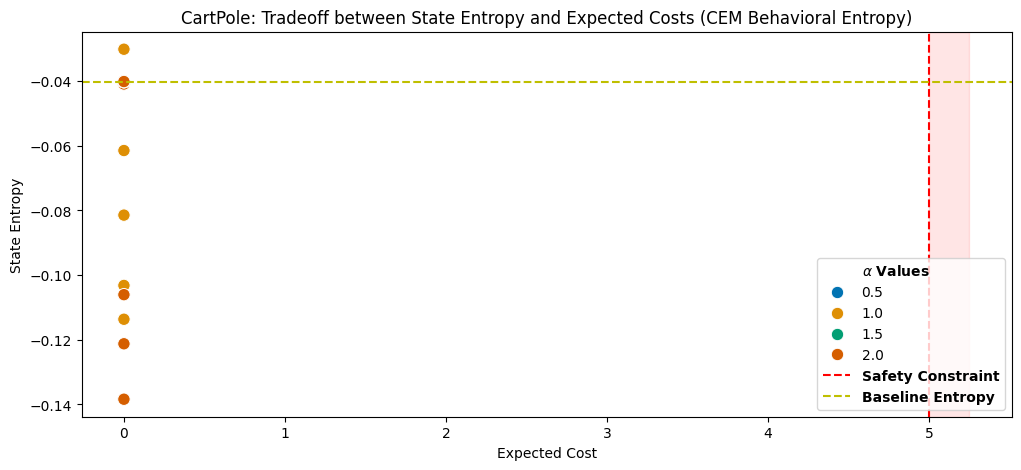

In [199]:
plot_tradeoff("CartPole-v1")

/tmp/ipykernel_1231917/1880668460.py:105: UserWarning: Mismatched number of handles and labels: len(handles) = 4 len(labels) = 7
  leg = ax.legend(handles=handles, labels=labels, frameon=True, loc="lower right")


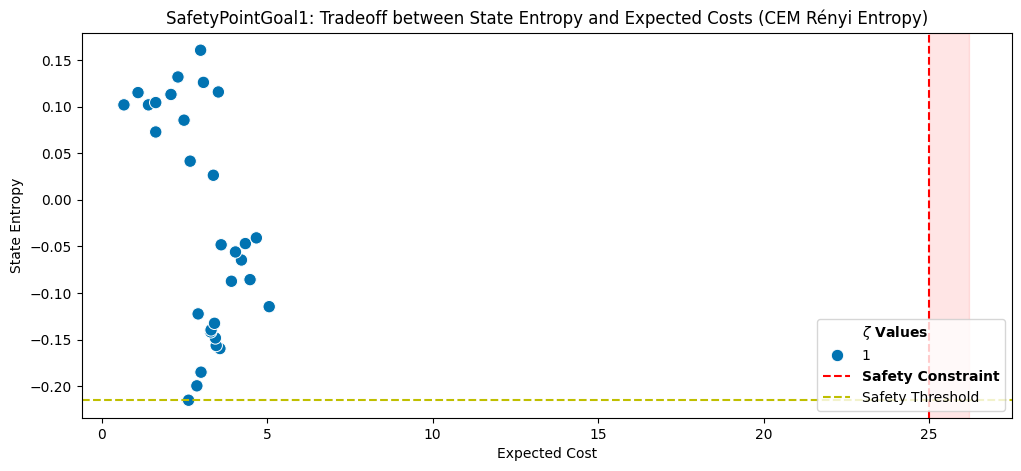

In [184]:
plot_tradeoff("SafetyPointGoal1-v0")